In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import sqlite3, pandas as pd
from contextlib import closing

DB_PATH = "/Users/farazahmed/Documents/GitHub/steam-discount-forecast/data/steam_sales.db"

In [41]:
with closing(sqlite3.connect(DB_PATH)) as conn:
    df = pd.read_sql("""
        WITH scoped_games AS (
            SELECT g.itad_id, g.appid, g.title, g.release_date,
                   g.early_access, g.mature
            FROM games g
            WHERE g.type='game'
              AND g.release_date BETWEEN '2021-01-01' AND '2024-12-31'
        ),
        tags_agg AS (
            SELECT gt.itad_id, GROUP_CONCAT(t.name, '; ') AS tags
            FROM game_tags gt JOIN tags t ON t.tag_id=gt.tag_id
            GROUP BY gt.itad_id
        ),
        first_hist_after_release AS (
            SELECT h.itad_id, MIN(h.ts_utc) AS first_ts
            FROM history_events h
            JOIN scoped_games sg ON sg.itad_id=h.itad_id
            WHERE date(h.ts_utc) >= date(sg.release_date)
            GROUP BY h.itad_id
        ),
        launch_price AS (
            SELECT fhar.itad_id, he.regular AS launch_price
            FROM first_hist_after_release fhar
            JOIN history_events he
              ON he.itad_id=fhar.itad_id AND he.ts_utc=fhar.first_ts
        ),
        first_sale_pick AS (
            SELECT h.itad_id, MIN(h.ts_utc) AS first_sale_ts
            FROM history_events h
            JOIN scoped_games sg ON sg.itad_id=h.itad_id
            WHERE date(h.ts_utc) > date(sg.release_date)
              AND h.price < h.regular    -- any discount, no 5% cutoff
            GROUP BY h.itad_id
        ),
        first_sale_enriched AS (
            SELECT fsp.itad_id,
                   fsp.first_sale_ts,
                   date(fsp.first_sale_ts) AS first_sale_date,
                   he.cut    AS first_sale_cut,
                   he.price  AS first_sale_price,
                   he.regular AS first_sale_regular
            FROM first_sale_pick fsp
            JOIN history_events he
              ON he.itad_id=fsp.itad_id AND he.ts_utc=fsp.first_sale_ts
        ),
        first_sale_labeled AS (
            SELECT fse.*,
                   CAST(ROUND(julianday(date(fse.first_sale_ts)) - julianday(g.release_date)) AS INTEGER)
                     AS days_to_first_sale
            FROM first_sale_enriched fse
            JOIN scoped_games g ON g.itad_id=fse.itad_id
        )
        SELECT
            sg.itad_id, sg.appid, sg.title, sg.release_date,
            sg.early_access, sg.mature,
            lp.launch_price,
            fsl.first_sale_date, fsl.first_sale_cut,
            fsl.first_sale_price, fsl.first_sale_regular,
            fsl.days_to_first_sale,
            ta.tags
        FROM scoped_games sg
        LEFT JOIN launch_price lp     ON lp.itad_id = sg.itad_id
        LEFT JOIN first_sale_labeled fsl ON fsl.itad_id = sg.itad_id
        LEFT JOIN tags_agg ta        ON ta.itad_id = sg.itad_id
        WHERE fsl.days_to_first_sale IS NOT NULL;
    """, conn)

df.head()

,itad_id,appid,title,release_date,early_access,mature,launch_price,first_sale_date,first_sale_cut,first_sale_price,first_sale_regular,days_to_first_sale,tags
0,018d937e-e9b7-73a9-84e1-1546a85c9841,NaN,Hacker,2024-03-29,0,0,0.99,2024-05-13,51,0.49,0.99,45,None
1,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,Princess of Zeven,2023-10-28,0,1,12.99,2023-12-21,20,10.39,12.99,54,RPG; Indie; Nudity; Sexual Content; Female Pro...
2,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,Hotel Magnate,2021-10-05,1,0,24.99,2021-11-24,20,19.99,24.99,50,Simulation; Sandbox; Management; Building; Res...
3,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,Step by Step,2023-10-06,0,0,9.99,2023-11-10,20,7.99,9.99,35,Hand-drawn; Casual; Platformer; 2D Platformer;...
4,018d937e-e9cb-728b-8309-979905bf3e82,965990.0,Destiny's Sword,2022-10-17,1,0,8.99,2022-12-22,40,5.39,8.99,66,Adventure; Simulation; Choices Matter; Sci-fi;...


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31246 entries, 0 to 31245
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             31246 non-null  object 
 1   appid               31118 non-null  float64
 2   title               31246 non-null  object 
 3   release_date        31246 non-null  object 
 4   early_access        31246 non-null  int64  
 5   mature              31246 non-null  int64  
 6   launch_price        31246 non-null  float64
 7   first_sale_date     31246 non-null  object 
 8   first_sale_cut      31246 non-null  int64  
 9   first_sale_price    31246 non-null  float64
 10  first_sale_regular  31246 non-null  float64
 11  days_to_first_sale  31246 non-null  int64  
 12  tags                31118 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 3.1+ MB


In [50]:
df.isna().sum()

itad_id                 0
appid                 128
title                   0
release_date            0
early_access            0
mature                  0
launch_price            0
first_sale_date         0
first_sale_cut          0
first_sale_price        0
first_sale_regular      0
days_to_first_sale      0
tags                  128
dtype: int64

In [51]:
# dropping the rowas with missing appid

df = df[~df['appid'].isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31118 entries, 1 to 31245
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             31118 non-null  object 
 1   appid               31118 non-null  float64
 2   title               31118 non-null  object 
 3   release_date        31118 non-null  object 
 4   early_access        31118 non-null  int64  
 5   mature              31118 non-null  int64  
 6   launch_price        31118 non-null  float64
 7   first_sale_date     31118 non-null  object 
 8   first_sale_cut      31118 non-null  int64  
 9   first_sale_price    31118 non-null  float64
 10  first_sale_regular  31118 non-null  float64
 11  days_to_first_sale  31118 non-null  int64  
 12  tags                31118 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 3.3+ MB


#### The dataset from Kaggle contains some other useful features like "Age", "Achievements", "Categories", etc. I will join these features into my data.

In [45]:
df2 = pd.read_csv("/Users/farazahmed/Documents/GitHub/steam-discount-forecast/Kaggle datasets/93182_steam_games.csv")
df2.head()

/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_89105/2777268084.py:1: DtypeWarning: Columns (3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("/Users/farazahmed/Documents/GitHub/steam-discount-forecast/Kaggle datasets/93182_steam_games.csv")


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,1424640,余烬,"Oct 3, 2020",20000 - 50000,0,0,3.99,0,'Ashes of war' is an anti war theme adventure ...,['Simplified Chinese'],...,0,0,0,宁夏华夏西部影视城有限公司,宁夏华夏西部影视城有限公司,"Single-player,Family Sharing","Adventure,Casual,Indie,RPG","Sokoban,RPG,Puzzle-Platformer,Exploration,Adve...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
1,402890,Nyctophilia,"Sep 23, 2015",50000 - 100000,0,0,0.00,0,NYCTOPHILIA Nyctophilia is an 2D psychological...,"['English', 'Russian']",...,0,0,0,Cat In A Jar Games,Cat In A Jar Games,Single-player,"Adventure,Free To Play,Indie","Free to Play,Indie,Adventure,Horror,2D,Pixel G...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
2,1151740,Prison Princess,"Apr 2, 2020",0 - 20000,0,0,19.99,0,"ABOUT Now nothing more than a phantom, can the...","['English', 'Simplified Chinese', 'Traditional...",...,0,0,0,qureate,qureate,"Single-player,Steam Achievements,Full controll...","Adventure,Indie","Sexual Content,Adventure,Indie,Nudity,Anime,Ma...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
3,875530,Dead In Time,"Oct 12, 2018",0 - 20000,0,0,7.99,0,Is a hardcore action with a non-trivial level ...,"['English', 'Russian']",...,0,0,0,Zelenov Artem,Zelenov Artem,"Single-player,Full controller support,Family S...","Action,Indie","Action,Indie,Souls-like,Fantasy,Early Access,R...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
4,1835360,Panacle: Back To Wild,"Mar 11, 2022",0 - 20000,2,0,3.99,0,Panacle: Back to the Wild is a indie card game...,"['English', 'Japanese', 'Simplified Chinese', ...",...,0,0,0,渡鸦游戏,"渡鸦游戏,电钮组","Single-player,Family Sharing","Indie,Strategy,Early Access","Trading Card Game,Turn-Based Strategy,Lore-Ric...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


In [56]:
# renaming "AppID" column to "appid" to match with df

df2.rename(columns={"AppID": "appid"}, inplace=True)

In [57]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93182 entries, 0 to 93181
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   appid                       93182 non-null  int64  
 1   Name                        93179 non-null  object 
 2   Release date                93182 non-null  object 
 3   Estimated owners            16462 non-null  object 
 4   Peak CCU                    93182 non-null  int64  
 5   Required age                93182 non-null  int64  
 6   Price                       93182 non-null  float64
 7   DLC count                   93182 non-null  int64  
 8   About the game              88392 non-null  object 
 9   Supported languages         93182 non-null  object 
 10  Full audio languages        93182 non-null  object 
 11  Reviews                     10599 non-null  object 
 12  Header image                93182 non-null  object 
 13  Website                     416

In [62]:
# merging the two dataframes on "appid" and keeping the columns "Required Age", "Windoes", "Mac", "Linux", "Achievements", "Developer", "Publisher", "Categories", "Genres"

df_merged = pd.merge(df, df2[['appid', 'Required age', 'Windows', 'Mac', 'Linux', 'Achievements', 'Developers', 'Publishers', 'Categories', 'Genres']], on='appid', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31118 entries, 0 to 31117
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             31118 non-null  object 
 1   appid               31118 non-null  float64
 2   title               31118 non-null  object 
 3   release_date        31118 non-null  object 
 4   early_access        31118 non-null  int64  
 5   mature              31118 non-null  int64  
 6   launch_price        31118 non-null  float64
 7   first_sale_date     31118 non-null  object 
 8   first_sale_cut      31118 non-null  int64  
 9   first_sale_price    31118 non-null  float64
 10  first_sale_regular  31118 non-null  float64
 11  days_to_first_sale  31118 non-null  int64  
 12  tags                31118 non-null  object 
 13  Required age        31115 non-null  float64
 14  Windows             31115 non-null  object 
 15  Mac                 31115 non-null  object 
 16  Linu

In [63]:
df_merged.isna().sum()

itad_id                 0
appid                   0
title                   0
release_date            0
early_access            0
mature                  0
launch_price            0
first_sale_date         0
first_sale_cut          0
first_sale_price        0
first_sale_regular      0
days_to_first_sale      0
tags                    0
Required age            3
Windows                 3
Mac                     3
Linux                   3
Achievements            3
Developers             32
Publishers            136
Categories              5
Genres                 34
dtype: int64

In [64]:
# dropping the rows with missing "Required age", "Windows", "Mac", "Linux", "Achievements", "Developer", "Publisher", "Categories", "Genres"
df_merged = df_merged[~df_merged['Required age'].isna()]
df_merged = df_merged[~df_merged['Windows'].isna()]
df_merged = df_merged[~df_merged['Mac'].isna()]
df_merged = df_merged[~df_merged['Linux'].isna()]
df_merged = df_merged[~df_merged['Achievements'].isna()]
df_merged = df_merged[~df_merged['Developers'].isna()]
df_merged = df_merged[~df_merged['Publishers'].isna()]
df_merged = df_merged[~df_merged['Categories'].isna()]
df_merged = df_merged[~df_merged['Genres'].isna()]
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   first_sale_date     30947 non-null  object 
 8   first_sale_cut      30947 non-null  int64  
 9   first_sale_price    30947 non-null  float64
 10  first_sale_regular  30947 non-null  float64
 11  days_to_first_sale  30947 non-null  int64  
 12  tags                30947 non-null  object 
 13  Required age        30947 non-null  float64
 14  Windows             30947 non-null  object 
 15  Mac                 30947 non-null  object 
 16  Linux    

In [69]:
# lets make quick check of duplicates based on appid
df_merged['appid'].duplicated().sum()

np.int64(0)

## Feature Selection: In this section I use qualitative and quantitative analysis to select features that are important and relevant for modelling 

#### From the users perspective it is not possible for them to have the data like: "first_sale_date", "first_sale_cut", "first_sale_price", "first_sale_regular". So it does not make sense to have them in the model.

In [70]:
# dropping "first_sale_date", "first_sale_price", "first_sale_regular", "first_sale_cut"

df_merged.drop(columns=['first_sale_date', 'first_sale_price', 'first_sale_regular', 'first_sale_cut'], inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   days_to_first_sale  30947 non-null  int64  
 8   tags                30947 non-null  object 
 9   Required age        30947 non-null  float64
 10  Windows             30947 non-null  object 
 11  Mac                 30947 non-null  object 
 12  Linux               30947 non-null  object 
 13  Achievements        30947 non-null  float64
 14  Developers          30947 non-null  object 
 15  Publishers          30947 non-null  object 
 16  Categorie

#### Analysing tags, categories and genres

In [65]:
df_merged[['tags', 'Categories', 'Genres']].head(10)

,tags,Categories,Genres
0,RPG; Indie; Nudity; Sexual Content; Female Pro...,"Single-player,Steam Cloud,Family Sharing","Indie,RPG"
1,Simulation; Sandbox; Management; Building; Res...,"Single-player,Steam Workshop,Family Sharing","Casual,Indie,Simulation,Strategy,Early Access"
2,Hand-drawn; Casual; Platformer; 2D Platformer;...,"Single-player,Multi-player,Co-op,Online Co-op,...","Action,Adventure,Casual,Indie,Strategy"
3,Adventure; Simulation; Choices Matter; Sci-fi;...,"Single-player,Family Sharing","Adventure,Indie,RPG,Simulation,Strategy,Early ..."
4,Indie; Horror; Retro; Immersive Sim; Survival ...,"Single-player,Partial Controller Support,Famil...","Action,Adventure,Indie,Simulation"
5,Singleplayer; Story Rich; Visual Novel; Romanc...,"Single-player,Steam Achievements,Family Sharing","Adventure,Indie,Simulation"
6,2D; Casual; Card Game; Football (Soccer); Soli...,"Single-player,Family Sharing",Casual
7,Base Building; Strategy; Deckbuilding; Funny; ...,"Single-player,Steam Achievements,Steam Cloud,F...","Indie,Strategy"
8,Adventure; RPG; Indie; Cute; Great Soundtrack,"Single-player,Multi-player,Co-op,Shared/Split ...","Adventure,Indie,RPG"
9,Wargame; Real Time Tactics; Military; Hero Sho...,"Single-player,Family Sharing","Action,Casual,Simulation,Strategy"


#### There are 400 plus unique tags present in the data. Having them in the model would require me to one-hot encode them which would explode the dimensionality and will not feasible for model training. I also think that it does not make sense to have tags that many or that granualar, also it is redundant with "Categories" and "Genres" present. For these reasons I will be dropping the tags columnm. 

In [71]:
# dropping "tags" column as it is redundant with "Categories" and "Genres"

df_merged.drop(columns=['tags'], inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   days_to_first_sale  30947 non-null  int64  
 8   Required age        30947 non-null  float64
 9   Windows             30947 non-null  object 
 10  Mac                 30947 non-null  object 
 11  Linux               30947 non-null  object 
 12  Achievements        30947 non-null  float64
 13  Developers          30947 non-null  object 
 14  Publishers          30947 non-null  object 
 15  Categories          30947 non-null  object 
 16  Genres   

#### Lets now analyse the "Categories" and "Genres" separately and see what information do they carry.

Unique categories: 38
Unique genres: 20
Top 10 categories cover: 85.7% of games
Top 10 genres cover:     99.3% of games


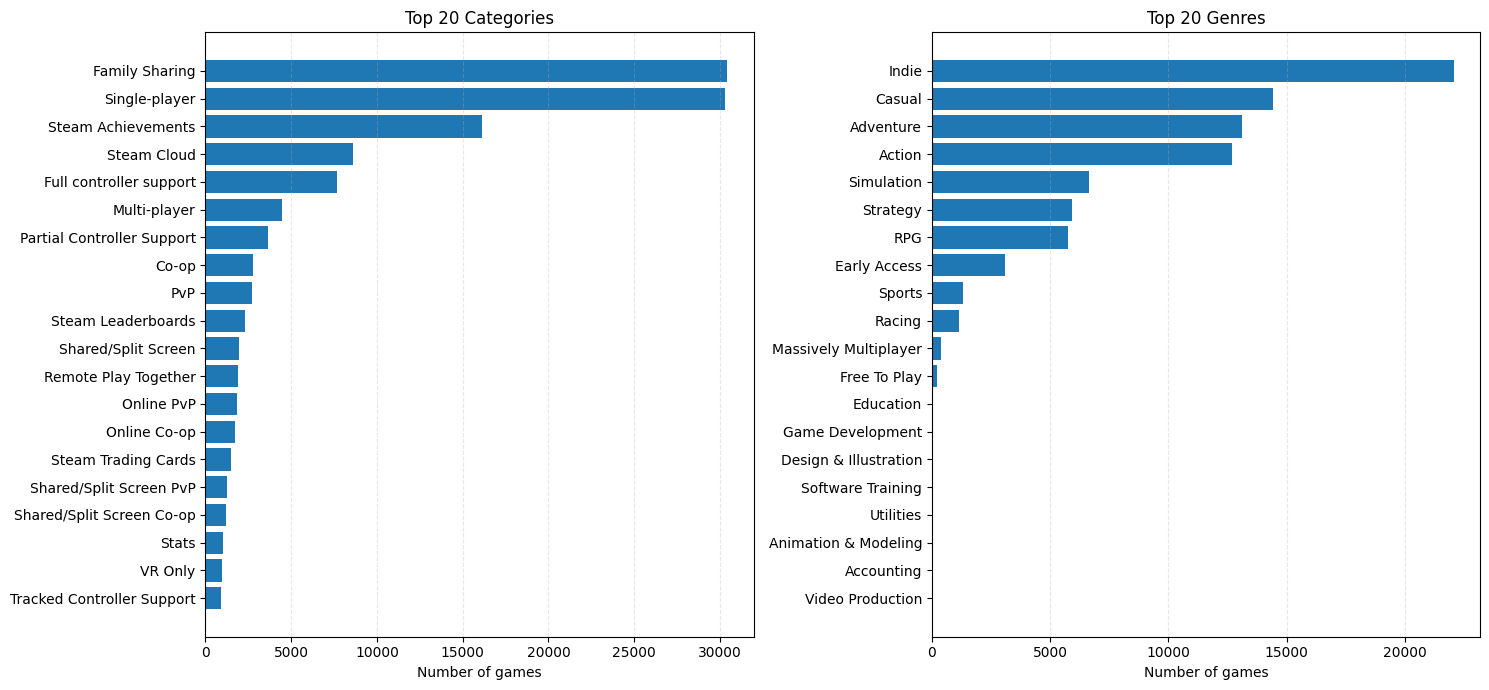

In [72]:
# helper to split comma/semicolon lists safely
def split_multi(x):
    if pd.isna(x): 
        return []
    parts = re.split(r"[;,]", str(x))
    return [p.strip() for p in parts if p.strip()]

# explode to one row per token
cats = df_merged["Categories"].apply(split_multi).explode()
gens = df_merged["Genres"].apply(split_multi).explode()

# counts
cat_counts = cats.value_counts()
gen_counts = gens.value_counts()

print("Unique categories:", cat_counts.shape[0])
print("Unique genres:", gen_counts.shape[0])

# quick coverage info (optional)
def coverage(series, k=10):
    return 100 * series.head(k).sum() / series.sum()
print(f"Top 10 categories cover: {coverage(cat_counts,10):.1f}% of games")
print(f"Top 10 genres cover:     {coverage(gen_counts,10):.1f}% of games")

# plot top-N bar charts
TOPN = 20
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# categories
cc = cat_counts.head(TOPN)[::-1]  # reverse for horizontal bars
axes[0].barh(cc.index, cc.values)
axes[0].set_title(f"Top {TOPN} Categories")
axes[0].set_xlabel("Number of games")
axes[0].grid(axis="x", linestyle="--", alpha=0.3)

# genres
gg = gen_counts.head(TOPN)[::-1]
axes[1].barh(gg.index, gg.values)
axes[1].set_title(f"Top {TOPN} Genres")
axes[1].set_xlabel("Number of games")
axes[1].grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

### Feature Selection: Categories, Genres, and Tags

In my analysis of the dataset, I noticed that **Categories** and **Genres** provide structured and interpretable information, while **Tags** are extremely granular with over 400 unique values.

- For **Categories**, I am deciding to keep only the three most important ones:  
  **Single-player, Multiplayer, and Family Sharing.**  
  These are the dominant categories across games, intuitive for users to understand, and easy to encode for the model. Dropping niche categories avoids unnecessary noise.

- For **Genres**, I am keeping the **top 11 genres up to Massively Multiplayer.**  
  These cover the vast majority of games, represent meaningful distinctions (e.g., RPG vs Strategy), and provide strong predictive value without overwhelming the model.

- For **Tags**, I chose to drop them entirely.  
  With 400+ unique tags, one-hot encoding would be impractical and would clutter both the model and the user interface. Tags are also inconsistent and too fine-grained to be useful at this stage.

In [73]:
# keeping only the categories: "Family Sharing", "Single-player", "Multi-player" rest as "Other"
# for genres keeping the top 11 genres rest as "Other"

top_categories = ["Family Sharing", "Single-player", "Multi-player"]
top_genres = gen_counts.head(11).index.tolist() # getting top 11 genres

def simplify_categories(x):
    cats = split_multi(x)
    simplified = [c if c in top_categories else "Other" for c in cats]
    return "; ".join(sorted(set(simplified)))  # unique and sorted

def simplify_genres(x):
    gens = split_multi(x)
    simplified = [g if g in top_genres else "Other" for g in gens]
    return "; ".join(sorted(set(simplified)))  # unique and sorted

df_merged['Categories'] = df_merged['Categories'].apply(simplify_categories)
df_merged['Genres'] = df_merged['Genres'].apply(simplify_genres)
df_merged[['Categories', 'Genres']].head(10)

,Categories,Genres
0,Family Sharing; Other; Single-player,Indie; RPG
1,Family Sharing; Other; Single-player,Casual; Early Access; Indie; Simulation; Strategy
2,Family Sharing; Multi-player; Other; Single-pl...,Action; Adventure; Casual; Indie; Strategy
3,Family Sharing; Single-player,Adventure; Early Access; Indie; RPG; Simulatio...
4,Family Sharing; Other; Single-player,Action; Adventure; Indie; Simulation
5,Family Sharing; Other; Single-player,Adventure; Indie; Simulation
6,Family Sharing; Single-player,Casual
7,Family Sharing; Other; Single-player,Indie; Strategy
8,Family Sharing; Multi-player; Other; Single-pl...,Adventure; Indie; RPG
9,Family Sharing; Single-player,Action; Casual; Simulation; Strategy


### Here a I am making and saving a dataset with additional columns for review scores. This data can be used to make sales predictions after the release date when the early reviews of the games come in.

In [83]:
q_review = """
WITH pivot AS (
  SELECT
    g.itad_id,
    g.appid,

    -- Steam
    MAX(CASE WHEN r.source='Steam' THEN r.score END) AS steam_score,
    MAX(CASE WHEN r.source='Steam' THEN r.count END) AS steam_count,

    -- OpenCritic
    MAX(CASE WHEN r.source='OpenCritic' THEN r.score END) AS opencritic_score,
    MAX(CASE WHEN r.source='OpenCritic' THEN r.count END) AS opencritic_count,

    -- Metascore (critics)
    MAX(CASE WHEN r.source='Metascore' THEN r.score END) AS metascore_score,
    MAX(CASE WHEN r.source='Metascore' THEN r.count END) AS metascore_count,

    -- Metacritic User Score
    MAX(CASE WHEN r.source='Metacritic User Score' THEN r.score END) AS mc_user_score,
    MAX(CASE WHEN r.source='Metacritic User Score' THEN r.count END) AS mc_user_count

  FROM games g
  LEFT JOIN reviews r ON r.itad_id = g.itad_id
  GROUP BY g.itad_id, g.appid
),
final AS (
  SELECT
    *,
    -- master score/count + which source was chosen
    CASE
      WHEN steam_score        IS NOT NULL THEN steam_score
      WHEN opencritic_score   IS NOT NULL THEN opencritic_score
      WHEN metascore_score    IS NOT NULL THEN metascore_score
      WHEN mc_user_score      IS NOT NULL THEN mc_user_score
      ELSE NULL
    END AS review_score,

    CASE
      WHEN steam_score        IS NOT NULL THEN steam_count
      WHEN opencritic_score   IS NOT NULL THEN opencritic_count
      WHEN metascore_score    IS NOT NULL THEN metascore_count
      WHEN mc_user_score      IS NOT NULL THEN mc_user_count
      ELSE NULL
    END AS review_count,

    CASE
      WHEN steam_score        IS NOT NULL THEN 'Steam'
      WHEN opencritic_score   IS NOT NULL THEN 'OpenCritic'
      WHEN metascore_score    IS NOT NULL THEN 'Metascore'
      WHEN mc_user_score      IS NOT NULL THEN 'Metacritic User Score'
      ELSE NULL
    END AS review_source
  FROM pivot
)
SELECT * FROM final;
"""

with closing(sqlite3.connect(DB_PATH)) as conn:
    df_reviews = pd.read_sql(q_review, conn)

df_reviews.head()

,itad_id,appid,steam_score,steam_count,opencritic_score,opencritic_count,metascore_score,metascore_count,mc_user_score,mc_user_count,review_score,review_count,review_source
0,018d937e-e9b5-71d6-a320-3543fb1ce11f,2080950.0,62.0,29.0,NaN,NaN,NaN,NaN,NaN,1.0,62.0,29.0,Steam
1,018d937e-e9b7-73a9-84e1-1546a85c9841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,77.0,109.0,NaN,NaN,NaN,NaN,NaN,NaN,77.0,109.0,Steam
3,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,61.0,389.0,NaN,NaN,NaN,NaN,NaN,1.0,61.0,389.0,Steam
4,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,96.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,96.0,56.0,Steam


In [84]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43140 entries, 0 to 43139
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   itad_id           43140 non-null  object 
 1   appid             42872 non-null  float64
 2   steam_score       39323 non-null  float64
 3   steam_count       39323 non-null  float64
 4   opencritic_score  1976 non-null   float64
 5   opencritic_count  4259 non-null   float64
 6   metascore_score   1487 non-null   float64
 7   metascore_count   3342 non-null   float64
 8   mc_user_score     2560 non-null   float64
 9   mc_user_count     6832 non-null   float64
 10  review_score      39346 non-null  float64
 11  review_count      39346 non-null  float64
 12  review_source     39346 non-null  object 
dtypes: float64(11), object(2)
memory usage: 4.3+ MB


In [85]:
df_reviews = df_reviews[['itad_id', 'appid', 'review_score', 'review_count', 'review_source']]
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43140 entries, 0 to 43139
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   itad_id        43140 non-null  object 
 1   appid          42872 non-null  float64
 2   review_score   39346 non-null  float64
 3   review_count   39346 non-null  float64
 4   review_source  39346 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.6+ MB


In [86]:
df_reviews.isna().sum()

itad_id             0
appid             268
review_score     3794
review_count     3794
review_source    3794
dtype: int64

In [87]:
# letting only the rows with non-null review_score and appid

df_reviews = df_reviews[~df_reviews['review_score'].isna()]
df_reviews = df_reviews[~df_reviews['appid'].isna()]
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39337 entries, 0 to 43139
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   itad_id        39337 non-null  object 
 1   appid          39337 non-null  float64
 2   review_score   39337 non-null  float64
 3   review_count   39337 non-null  float64
 4   review_source  39337 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.8+ MB


In [90]:
# merging df_merged with df_reviews on "appid" and "itad_id" and keeping only one itad_id column

df_v2 = pd.merge(df_merged, df_reviews, on=['appid', 'itad_id'], how='left')
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   days_to_first_sale  30947 non-null  int64  
 8   Required age        30947 non-null  float64
 9   Windows             30947 non-null  object 
 10  Mac                 30947 non-null  object 
 11  Linux               30947 non-null  object 
 12  Achievements        30947 non-null  float64
 13  Developers          30947 non-null  object 
 14  Publishers          30947 non-null  object 
 15  Categories          30947 non-null  object 
 16  Genr

In [91]:
# saving to csv

df_v2.to_csv("steam_games_enriched.csv", index=False)
df_v2.head()

,itad_id,appid,title,release_date,early_access,mature,launch_price,days_to_first_sale,Required age,Windows,Mac,Linux,Achievements,Developers,Publishers,Categories,Genres,review_score,review_count,review_source
0,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,Princess of Zeven,2023-10-28,0,1,12.99,54,0.0,True,False,False,0.0,Lovely Pretty Ultra Loving You,Kagura Games,Family Sharing; Other; Single-player,Indie; RPG,77.0,109.0,Steam
1,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,Hotel Magnate,2021-10-05,1,0,24.99,50,0.0,True,True,True,0.0,Arcade Oven,Arcade Oven,Family Sharing; Other; Single-player,Casual; Early Access; Indie; Simulation; Strategy,61.0,389.0,Steam
2,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,Step by Step,2023-10-06,0,0,9.99,35,0.0,True,False,False,19.0,"Tripp Rainey,Brice DiPiazza",Trippster Studios,Family Sharing; Multi-player; Other; Single-pl...,Action; Adventure; Casual; Indie; Strategy,96.0,56.0,Steam
3,018d937e-e9cb-728b-8309-979905bf3e82,965990.0,Destiny's Sword,2022-10-17,1,0,8.99,66,0.0,True,False,False,39.0,2Dogs Games Ltd.,Bonus Stage Publishing,Family Sharing; Single-player,Adventure; Early Access; Indie; RPG; Simulatio...,56.0,23.0,Steam
4,018d937e-e9ce-718b-9715-111f51df7457,896520.0,Stay Out of the House,2022-10-14,0,0,14.99,39,0.0,True,True,False,29.0,Puppet Combo,Puppet Combo,Family Sharing; Other; Single-player,Action; Adventure; Indie; Simulation,94.0,1350.0,Steam


### Lets go back to working with our pre-release version of the dataset.

In [92]:
df_merged.head()

,itad_id,appid,title,release_date,early_access,mature,launch_price,days_to_first_sale,Required age,Windows,Mac,Linux,Achievements,Developers,Publishers,Categories,Genres
0,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,Princess of Zeven,2023-10-28,0,1,12.99,54,0.0,True,False,False,0.0,Lovely Pretty Ultra Loving You,Kagura Games,Family Sharing; Other; Single-player,Indie; RPG
1,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,Hotel Magnate,2021-10-05,1,0,24.99,50,0.0,True,True,True,0.0,Arcade Oven,Arcade Oven,Family Sharing; Other; Single-player,Casual; Early Access; Indie; Simulation; Strategy
2,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,Step by Step,2023-10-06,0,0,9.99,35,0.0,True,False,False,19.0,"Tripp Rainey,Brice DiPiazza",Trippster Studios,Family Sharing; Multi-player; Other; Single-pl...,Action; Adventure; Casual; Indie; Strategy
3,018d937e-e9cb-728b-8309-979905bf3e82,965990.0,Destiny's Sword,2022-10-17,1,0,8.99,66,0.0,True,False,False,39.0,2Dogs Games Ltd.,Bonus Stage Publishing,Family Sharing; Single-player,Adventure; Early Access; Indie; RPG; Simulatio...
4,018d937e-e9ce-718b-9715-111f51df7457,896520.0,Stay Out of the House,2022-10-14,0,0,14.99,39,0.0,True,True,False,29.0,Puppet Combo,Puppet Combo,Family Sharing; Other; Single-player,Action; Adventure; Indie; Simulation


In [93]:
# converting "Windoes", "Mac", "Linux", "Achievements", "early_access", "mature" to integer

df_merged['Windows'] = df_merged['Windows'].astype(int)
df_merged['Mac'] = df_merged['Mac'].astype(int)
df_merged['Linux'] = df_merged['Linux'].astype(int)
df_merged['Achievements'] = df_merged['Achievements'].astype(int)
df_merged['early_access'] = df_merged['early_access'].astype(int)
df_merged['mature'] = df_merged['mature'].astype(int)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   days_to_first_sale  30947 non-null  int64  
 8   Required age        30947 non-null  float64
 9   Windows             30947 non-null  int64  
 10  Mac                 30947 non-null  int64  
 11  Linux               30947 non-null  int64  
 12  Achievements        30947 non-null  int64  
 13  Developers          30947 non-null  object 
 14  Publishers          30947 non-null  object 
 15  Categories          30947 non-null  object 
 16  Genres   

### Feature engineering

#### Lets extract temporal features from "release_date", here's what I am looking to extract and my reasoning behind it,

1. ##### year: This captures trends over time.
2. ##### month: For seasonal patterns there are big sales in November (Autumn Sale, Black Friday) and December (Winter Sale)
3. ##### day_of_month: Sometimes publishers align with marketing cycles (early vs. end-of-month)
4. ##### day_of_week: Friday releases are common for reaching bigger audience, higher initial sales, may affect timing of first discount.
5. ##### quarter: Q1, Q2, Q3, Q4. Q4 often coincides with holiday season discounts
6. ##### is_holiday_season(binary 1/0): 1 if November-December else 0
7. ##### is_summer_sale_window(binary 1/0): June/July often aligns with the big Steam Summer Sale
8. ##### time_since_steam_launch(since September 2003): Difference in days from Steam’s platform age (to capture shifts in store-wide discount strategies). 

In [97]:
# extracting temporal features from "release_date"

df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')

df_merged['release_year'] = df_merged['release_date'].dt.year
df_merged['release_month'] = df_merged['release_date'].dt.month
df_merged['release_day'] = df_merged['release_date'].dt.day
df_merged['release_quarter'] = df_merged['release_date'].dt.quarter
df_merged['release_weekday'] = df_merged['release_date'].dt.weekday

# is_holiday_season(binary 1/0): 1 if November-December else 0
df_merged['is_holiday_season'] = df_merged['release_month'].apply(lambda x: 1 if x in [11, 12] else 0)

# is_summer_sale_window(binary 1/0): June/July often aligns with the big Steam Summer Sale
df_merged['is_summer_sale_window'] = df_merged['release_month'].apply(lambda x: 1 if x in [6, 7] else 0)

# time_since_steam_launch(since September 2003): Difference in days from Steam’s platform age (to capture shifts in store-wide discount strategies)
steam_launch_date = pd.to_datetime('2003-09-12')
df_merged['time_since_steam_launch'] = (df_merged['release_date'] - steam_launch_date).dt.days

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  30947 non-null  object        
 1   appid                    30947 non-null  float64       
 2   title                    30947 non-null  object        
 3   release_date             30947 non-null  datetime64[ns]
 4   early_access             30947 non-null  int64         
 5   mature                   30947 non-null  int64         
 6   launch_price             30947 non-null  float64       
 7   days_to_first_sale       30947 non-null  int64         
 8   Required age             30947 non-null  float64       
 9   Windows                  30947 non-null  int64         
 10  Mac                      30947 non-null  int64         
 11  Linux                    30947 non-null  int64         
 12  Achievements             30947 non-nu

#### Series Indicator: I am adding a feture that slassifies a game as a part of a series like for example, Assassin's Creed, Assassin's Creed 2, etc. This will capture the effect of market power and reputation effects.

### Series / Franchise Identification (`is_series`)

I flag a game as part of a series (`is_series = 1`) using robust title-based cues. The logic looks for **strong sequel patterns** and (by design) also includes **re-releases/editions** to capture franchise continuity.

**Strong sequel cues (examples):**
- Explicit numbering in the title: Arabic numerals **2–20** (e.g., *Game 2*, *Game 10*) or Roman numerals **II–XII** (e.g., *Game IV*).
- Structured sequel words with numbers: **Episode**, **Part**, **Chapter**, **Season** followed by a number/roman (e.g., *Game – Episode 3*, *Part II*).
- Collection/series terms: **Trilogy**, **Tetralogy/Quadrilogy**, **Saga**, **Anthology**.

**Re-release / edition cues (included by choice):**
- **Remaster/Remastered**, **Remake**, **Redux**, **HD Remaster**  
- **Definitive Edition**, **Enhanced Edition**, **Director’s Cut**, **Complete Edition**, **GOTY / Game of the Year**, **Anniversary**, **Ultra Deluxe**

**False-positive guards:**
- Avoid matching plain **years** (e.g., “2020”, “2024”) as sequels.
- Optionally exclude phrases like **“Season Pass”** from season-based matches.

**Why include re-releases?**  
They indicate an existing franchise/IP with established audience and pricing patterns, which often correlates with discount strategy. For this project, I use the **inclusive** flag that counts both sequels and re-releases as series.

**Notes & limitations:**
- This is a **title-pattern heuristic**; it won’t catch all franchises (e.g., subtitled sequels with no numbers) and may miss rare naming schemes.
- The patterns are configurable; I can refine them if noise appears during audit (e.g., add exclusions or extend roman numerals).

Result: a reproducible binary feature `is_series` (inclusive) that captures franchise/continuity signals likely relevant to discount timing.

In [99]:
# adding a column "is_series" binary 1/0 if the title contains "Episode", "Part", "Chapter", "Season", "Saga", "Trilogy", "Quadrology", "Remastered"

# --- build regexes (case-insensitive) ---

# 1) Strong sequel indicators
#   - Roman numerals: II, III, IV, V, VI, VII, VIII, IX, X, XI, XII
#   - Arabic numerals: 2–20 (bounded as separate words to avoid years like 2020)
#   - Words with explicit numbering: Episode/Part/Chapter/Season + number/roman
#   - Collection words: Trilogy, Tetralogy/Quadrilogy, Saga, Anthology
roman_nums   = r"(?:ii|iii|iv|v|vi|vii|viii|ix|x|xi|xii)"
arabic_nums  = r"(?:[2-9]|1[0-9]|20)"                 # 2..20
num_token    = rf"(?:{arabic_nums}|{roman_nums})"
word_number  = rf"(?:episode|part|chapter|season)\s*{num_token}\b"

strong_tokens = [
    rf"\b{num_token}\b",                               # "Game II", "Game 2"
    word_number,                                       # "Episode 3", "Part IV"
    r"\btrilogy\b",
    r"\btetralogy\b|\bquadrilogy\b|\bquadrology\b",    # common spellings
    r"\bsaga\b",
    r"\banthology\b",
]

STRONG_RE = re.compile("|".join(strong_tokens), re.IGNORECASE)

# 2) Soft re-release / edition indicators (not always a series, but often implies prior title)
soft_tokens = [
    r"\bremaster(?:ed)?\b",                            # Remaster, Remastered
    r"\bremake\b",
    r"\bredux\b",
    r"\bdefinitive\s+edition\b",
    r"\benhanced\s+edition\b",
    r"\bdirector'?s\s+cut\b",
    r"\bhd\s+remaster\b",
    r"\bgoty\b|\bgame\s+of\s+the\s+year\b",
    r"\bcomplete\s+edition\b|\bultra\s+deluxe\b|\banniversary\b",
]
SOFT_RE = re.compile("|".join(soft_tokens), re.IGNORECASE)

# --- helpers ---

def is_series_title(title: str, include_soft=False) -> int:
    """
    Return 1 if title looks like part of a series.
    include_soft=True will also count remasters/editions as series.
    """
    if not isinstance(title, str) or not title.strip():
        return 0
    t = title.strip()
    if STRONG_RE.search(t):
        return 1
    if include_soft and SOFT_RE.search(t):
        return 1
    return 0

def has_soft_rerelease(title: str) -> int:
    if not isinstance(title, str) or not title.strip():
        return 0
    return int(bool(SOFT_RE.search(title)))

# --- apply to your DataFrame (df_merged) ---

# Strict series only (recommended for modeling)
df_merged["is_series_strict"] = df_merged["title"].apply(is_series_title)

# If you want a single flag that also treats remasters/editions as series:
df_merged["is_series_inclusive"] = df_merged["title"].apply(lambda s: is_series_title(s, include_soft=True))

# Optional: keep a separate soft flag for analysis
df_merged["is_rerelease_soft"] = df_merged["title"].apply(has_soft_rerelease)

# Choose the one you want to use as your feature:
# df_merged["is_series"] = df_merged["is_series_strict"]        # conservative
# or
# df_merged["is_series"] = df_merged["is_series_inclusive"]     # broader

In [106]:
# keeping only the inclusive version

df_merged.drop(columns=['is_series_strict', 'is_rerelease_soft'], inplace=True)
df_merged.rename(columns={'is_series_inclusive': 'is_series'}, inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  30947 non-null  object        
 1   appid                    30947 non-null  float64       
 2   title                    30947 non-null  object        
 3   release_date             30947 non-null  datetime64[ns]
 4   early_access             30947 non-null  int64         
 5   mature                   30947 non-null  int64         
 6   launch_price             30947 non-null  float64       
 7   days_to_first_sale       30947 non-null  int64         
 8   Required age             30947 non-null  float64       
 9   Windows                  30947 non-null  int64         
 10  Mac                      30947 non-null  int64         
 11  Linux                    30947 non-null  int64         
 12  Achievements             30947 non-nu

#### I am adding a "publisher_game_count" to the dataset which contains the number of games published by a specific publisher. This gives an idea of how big or small a publisher is and would help in capturing trends for publisher behaviour in giving discount.

In [112]:
# adding a "publisher_game_count" column that counts how many games each publisher has in the dataset

publisher_counts = df_merged['Publishers'].value_counts().to_dict()
df_merged['publisher_game_count'] = df_merged['Publishers'].map(publisher_counts)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  30947 non-null  object        
 1   appid                    30947 non-null  float64       
 2   title                    30947 non-null  object        
 3   release_date             30947 non-null  datetime64[ns]
 4   early_access             30947 non-null  int64         
 5   mature                   30947 non-null  int64         
 6   launch_price             30947 non-null  float64       
 7   days_to_first_sale       30947 non-null  int64         
 8   Required age             30947 non-null  float64       
 9   Windows                  30947 non-null  int64         
 10  Mac                      30947 non-null  int64         
 11  Linux                    30947 non-null  int64         
 12  Achievements             30947 non-nu